In [1]:
# analysis.ipynb

"""
Analysis Script
Author: Imran Feisal
Date: 31/10/2024
Description:
This Jupyter notebook performs clustering and visualization on the latent features
and TabNet predictions, uses advanced clustering methods to determine the optimal
number of clusters, selects the best clustering algorithm based on validation metrics,
and provides in-depth analysis.

Inspiration: 
- Xu, Y., Goodacre, S., & Hall, M. (2018). Developing a Dynamic Health Index Using Machine Learning to Predict Patient Deterioration. IEEE Journal of Biomedical and Health Informatics, 22(3), 919-925.
- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint arXiv:1802.03426.
"""


'\nAnalysis Script\nAuthor: Imran Feisal\nDate: 31/10/2024\nDescription:\nThis Jupyter notebook performs clustering and visualization on the latent features\nand TabNet predictions, uses advanced clustering methods to determine the optimal\nnumber of clusters, selects the best clustering algorithm based on validation metrics,\nand provides in-depth analysis.\n\nInspiration: \n- Xu, Y., Goodacre, S., & Hall, M. (2018). Developing a Dynamic Health Index Using Machine Learning to Predict Patient Deterioration. IEEE Journal of Biomedical and Health Informatics, 22(3), 919-925.\n- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint arXiv:1802.03426.\n'


# Import necessary libraries

In [2]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from scipy.stats import f_oneway, kruskal, shapiro, levene

import warnings
warnings.filterwarnings('ignore')



# Set random seed for reproducibility

In [3]:
np.random.seed(42)

In [4]:
# Load latent features from VAE
latent_features = pd.read_csv('latent_features_vae.csv')

# Load TabNet predictions
tabnet_predictions = pd.read_csv('tabnet_predictions.csv')

# Merge data
data = latent_features.merge(tabnet_predictions, on='Id', how='inner')

# Extract the features for clustering (exclude 'Id' and 'Predicted_Health_Index')
X = data.drop(columns=['Id', 'Predicted_Health_Index'])
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Initialize a dictionary to store clustering results
clustering_results = {}



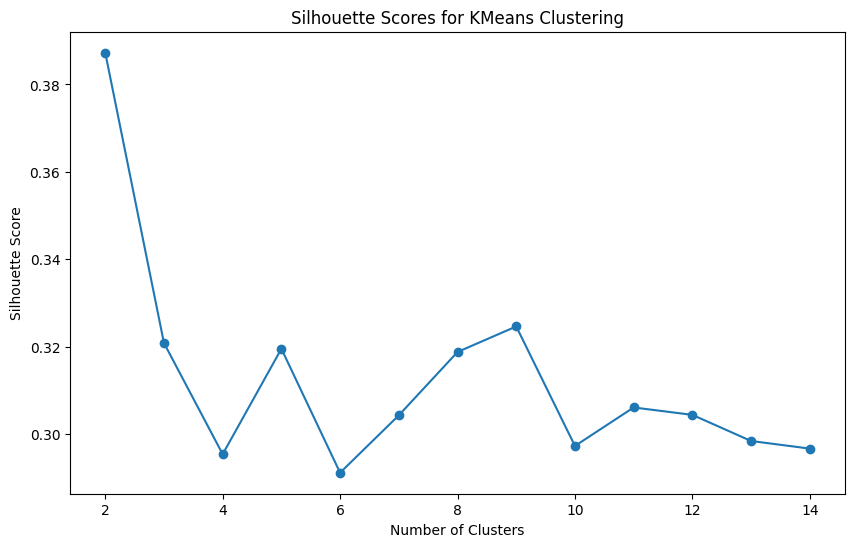

In [5]:
# ------------------------------
# KMeans Clustering
# ------------------------------

# Determine optimal number of clusters using Silhouette Score
silhouette_scores_kmeans = []
cluster_range = range(2, 15)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores_kmeans.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [6]:
# Optimal number of clusters for KMeans
optimal_clusters_kmeans = cluster_range[np.argmax(silhouette_scores_kmeans)]
print(f"Optimal number of clusters for KMeans: {optimal_clusters_kmeans}")

# Perform KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


Optimal number of clusters for KMeans: 2


In [ ]:
# ------------------------------
# Agglomerative Clustering
# ------------------------------

# Determine optimal number of clusters using Silhouette Score
silhouette_scores_agg = []
for n_clusters in cluster_range:
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_cluster.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, agg_labels)
    silhouette_scores_agg.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_agg, marker='o', color='green')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
# Optimal number of clusters for Agglomerative Clustering
optimal_clusters_agg = cluster_range[np.argmax(silhouette_scores_agg)]
print(f"Optimal number of clusters for Agglomerative Clustering: {optimal_clusters_agg}")

# Perform Agglomerative Clustering with optimal number of clusters
agg_cluster = AgglomerativeClustering(n_clusters=optimal_clusters_agg)
agg_labels = agg_cluster.fit_predict(X_scaled)


In [ ]:
# ------------------------------
# DBSCAN Clustering
# ------------------------------

from sklearn.neighbors import NearestNeighbors

# Determine optimal epsilon using k-distance graph
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()


In [ ]:
# From the plot, choose an epsilon value where the distance starts to increase sharply
epsilon = 1.5  # Adjust based on the k-distance graph

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)


In [ ]:
# ------------------------------
# Cluster Validation Metrics
# ------------------------------

# KMeans Scores
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
ch_score_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
db_score_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

# Agglomerative Clustering Scores
silhouette_agg = silhouette_score(X_scaled, agg_labels)
ch_score_agg = calinski_harabasz_score(X_scaled, agg_labels)
db_score_agg = davies_bouldin_score(X_scaled, agg_labels)

# DBSCAN Scores (only if more than one cluster)
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels)
    ch_score_dbscan = calinski_harabasz_score(X_scaled, dbscan_labels)
    db_score_dbscan = davies_bouldin_score(X_scaled, dbscan_labels)
else:
    silhouette_dbscan = ch_score_dbscan = db_score_dbscan = np.nan

# Compile results into a DataFrame
validation_scores = pd.DataFrame({
    'Clustering_Method': ['KMeans', 'Agglomerative', 'DBSCAN'],
    'Silhouette_Score': [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    'Calinski_Harabasz_Score': [ch_score_kmeans, ch_score_agg, ch_score_dbscan],
    'Davies_Bouldin_Score': [db_score_kmeans, db_score_agg, db_score_dbscan]
})

display(validation_scores)


In [ ]:
# Based on the validation metrics, select the best clustering method
# Criteria: Highest Silhouette Score, Highest Calinski-Harabasz Score, Lowest Davies-Bouldin Score

# For simplicity, we can rank the methods
validation_scores['Silhouette_Rank'] = validation_scores['Silhouette_Score'].rank(ascending=False)
validation_scores['CH_Rank'] = validation_scores['Calinski_Harabasz_Score'].rank(ascending=False)
validation_scores['DB_Rank'] = validation_scores['Davies_Bouldin_Score'].rank(ascending=True)

# Compute average rank
validation_scores['Average_Rank'] = validation_scores[['Silhouette_Rank', 'CH_Rank', 'DB_Rank']].mean(axis=1)

# Select the method with the best (lowest) average rank
best_method = validation_scores.loc[validation_scores['Average_Rank'].idxmin(), 'Clustering_Method']
print(f"Best clustering method based on validation metrics: {best_method}")


In [ ]:
# Add the best clustering labels to the data
if best_method == 'KMeans':
    data['Cluster'] = kmeans_labels
    n_clusters = optimal_clusters_kmeans
elif best_method == 'Agglomerative':
    data['Cluster'] = agg_labels
    n_clusters = optimal_clusters_agg
elif best_method == 'DBSCAN':
    data['Cluster'] = dbscan_labels
    n_clusters = n_clusters_dbscan


Map Clusters to Severity Index

In [ ]:
# Exclude noise points (-1) if using DBSCAN
if best_method == 'DBSCAN':
    data = data[data['Cluster'] != -1]

# Map clusters to severity index based on mean Predicted_Health_Index in each cluster
cluster_severity = data.groupby('Cluster')['Predicted_Health_Index'].mean().sort_values().reset_index()
cluster_severity['Severity_Index'] = range(1, n_clusters + 1)
severity_mapping = cluster_severity.set_index('Cluster')['Severity_Index'].to_dict()
data['Severity_Index'] = data['Cluster'].map(severity_mapping)


In [ ]:
# ------------------------------
# t-SNE Visualization
# ------------------------------

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title(f't-SNE Visualization of Latent Features ({best_method})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Severity Index')
plt.show()


In [ ]:
# ------------------------------
# UMAP Visualization
# ------------------------------

reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(X_scaled)

# Plot UMAP results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title(f'UMAP Visualization of Latent Features ({best_method})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Severity Index')
plt.show()


In [ ]:
# ------------------------------
# Statistical Analysis
# ------------------------------

# Check assumptions for ANOVA
# 1. Normality within each group
normality_pvalues = []
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]['Predicted_Health_Index']
    stat, p = shapiro(cluster_data)
    normality_pvalues.append(p)

# If any p-value is less than 0.05, normality is violated
if any(p < 0.05 for p in normality_pvalues):
    print("Normality assumption violated in at least one cluster. Using Kruskal-Wallis test.")
    # Perform Kruskal-Wallis test
    kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
    print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")
else:
    # Check homogeneity of variances
    stat, p = levene(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
    if p < 0.05:
        print("Homogeneity of variances assumption violated. Using Kruskal-Wallis test.")
        # Perform Kruskal-Wallis test
        kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
        print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")
    else:
        # Perform ANOVA
        anova_result = f_oneway(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
        print(f"ANOVA F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")


In [ ]:
# ------------------------------
# Cluster Profiles
# ------------------------------

# Identify numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
# Remove 'Id' and 'Cluster' if they exist in the list
for col in ['Id', 'Cluster']:
    if col in numeric_columns:
        numeric_columns.remove(col)

cluster_summary = data.groupby('Severity_Index')[numeric_columns].mean().reset_index()

# Display cluster profiles
display(cluster_summary)


In [ ]:
# ------------------------------
# Save Analysis Results
# ------------------------------

data.to_csv('analysis_results.csv', index=False)
print("Analysis results saved.")

# Optionally, save cluster profiles
cluster_summary.to_csv('cluster_profiles.csv', index=False)
print("Cluster profiles saved.")
